In [61]:
from jupyterthemes import jtplot
jtplot.style('onedork')

## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [62]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [63]:
#I made a number N that varies in time since it was asked to define it in the 
#range between 10000 and the maximum number of rows

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

file = open('/Users/tommasofaorlin/data/data_000637.txt', 'r')
rows_number = 0
for line in file:
    rows_number+=1
    
file_ = '/Users/tommasofaorlin/data/data_000637.txt'
total_ = pd.read_csv(file_)
df = pd.read_csv(file_).head(np.random.randint(10000,rows_number))

print(type(file))
print(type(file_))

print(df)

<class '_io.TextIOWrapper'>
<class 'str'>
        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0          1     0          123  3869200167        2374        26
1          1     0          124  3869200167        2374        27
2          1     0           63  3869200167        2553        28
3          1     0           64  3869200167        2558        19
4          1     0           64  3869200167        2760        25
...      ...   ...          ...         ...         ...       ...
855816     1     0          139  3869208045        1963         0
855817     1     0           61  3869208045        1957         5
855818     1     0           62  3869208045        1957         1
855819     1     0           64  3869208045        1961        18
855820     1     1            2  3869208045        2133        29

[855821 rows x 6 columns]


2. Find out the number of BX in a ORBIT (the value 'x').

In [65]:
max_ = df['BX_COUNTER'].max()
min_ = df['BX_COUNTER'].min()
x = max_ - min_
print('x is: ', x)

x is:  3563


3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [66]:
print("The data taking lasted on the total database: ", (total_['ORBIT_CNT'].max()-total_['ORBIT_CNT'].min())*3563*25e-9, )

#this must vary since it is defined on a random number of rows between 10000 and rows_number
print("The data taking lasted: ", (df['ORBIT_CNT'].max()-df['ORBIT_CNT'].min())*3563*25e-9, )

The data taking lasted on the total database:  0.9801812999999999
The data taking lasted:  0.70173285


4. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [67]:
df['ABS_TIME'] = ((df['ORBIT_CNT']-df['ORBIT_CNT'].min())*3563*25 +
                            df['BX_COUNTER']*25 + 
                            df['TDC_MEAS']*(5/6) )*10**-9
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000059
1,1,0,124,3869200167,2374,27,0.000059
2,1,0,63,3869200167,2553,28,0.000064
3,1,0,64,3869200167,2558,19,0.000064
4,1,0,64,3869200167,2760,25,0.000069
...,...,...,...,...,...,...,...
855816,1,0,139,3869208045,1963,0,0.701782
855817,1,0,61,3869208045,1957,5,0.701782
855818,1,0,62,3869208045,1957,1,0.701782
855819,1,0,64,3869208045,1961,18,0.701782


5. Replace the values (all 1) of the HEAD column randomly with 0 or 1

In [68]:
df['HEAD'] = np.random.randint(0, 2, len(df))
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000059
1,1,0,124,3869200167,2374,27,0.000059
2,0,0,63,3869200167,2553,28,0.000064
3,0,0,64,3869200167,2558,19,0.000064
4,1,0,64,3869200167,2760,25,0.000069
...,...,...,...,...,...,...,...
855816,1,0,139,3869208045,1963,0,0.701782
855817,0,0,61,3869208045,1957,5,0.701782
855818,1,0,62,3869208045,1957,1,0.701782
855819,0,0,64,3869208045,1961,18,0.701782


6. Create a new DataFrame that contains only the rows with HEAD=1.

In [69]:
df_ = df[df['HEAD'] == 1]
df_

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000059
1,1,0,124,3869200167,2374,27,0.000059
4,1,0,64,3869200167,2760,25,0.000069
6,1,0,61,3869200167,2772,14,0.000069
8,1,0,62,3869200167,2774,21,0.000069
...,...,...,...,...,...,...,...
855812,1,0,62,3869208045,1949,28,0.701782
855813,1,1,36,3869208045,1953,21,0.701782
855814,1,0,59,3869208045,1958,29,0.701782
855816,1,0,139,3869208045,1963,0,0.701782


7. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

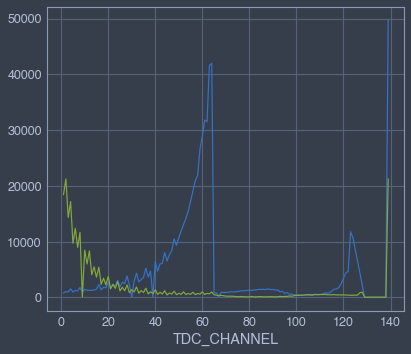

In [70]:
df[df["FPGA"] == 0].groupby('TDC_CHANNEL').count()['HEAD'].plot()
df[df["FPGA"] == 1].groupby('TDC_CHANNEL').count()['HEAD'].plot()
plt.show()

8. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [71]:
df.sort_values(by = 'TDC_CHANNEL', ascending = False)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
472933,1,1,139,3869204943,1230,0,0.425453
49524,0,0,139,3869200659,2422,0,0.043885
420333,1,0,139,3869204400,2787,0,0.377124
180330,0,0,139,3869201962,764,0,0.159909
841633,1,0,139,3869207947,1438,0,0.693039
...,...,...,...,...,...,...,...
364722,1,1,1,3869203827,3049,25,0.326091
364716,0,1,1,3869203827,3044,6,0.326091
72957,0,1,1,3869200892,1769,0,0.064624
834978,1,1,1,3869207904,26,19,0.689174


9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [73]:
print('The number of unique orbit is: ',
      df['ORBIT_CNT'].nunique())
print('The number of unique orbits with at least one measurement from TDC_CHANNEL = 139: ',
      df[df['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique())

print('The number of unique orbit is: ',
      total_['ORBIT_CNT'].nunique())
print('The number of unique orbits with at least one measurement from TDC_CHANNEL = 139: ',
      total_[total_['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique())

The number of unique orbit is:  7875
The number of unique orbits with at least one measurement from TDC_CHANNEL = 139:  7850
The number of unique orbit is:  11001
The number of unique orbits with at least one measurement from TDC_CHANNEL = 139:  10976


In [2]:
import pandas as pd
file_ = '/Users/tommasofaorlin/data/data_000637.txt'
total_ = pd.read_csv(file_)

print('The number of unique orbit is: ',
      total_['ORBIT_CNT'].nunique())

The number of unique orbit is:  11001
